<link rel="stylesheet" href="fonts/css/font-awesome.min.css">
[А. Л.](https://capissimo.github.io/pythonfordatascience), 2017

https://capissimo.github.io/pythonfordatascience

## Глава 03. Корреляция

### Содержание

- [Обследование данных](#Обследование-данных)
- [Визуализация данных](#Визуализация-данных)
- [Логнормальное распределение](#Логнормальное-распределение)
- [Ковариация](#Ковариация)
- [Корреляция Пирсона](#Корреляция-Пирсона)
- [Проверка статистических гипотез](#Проверка-статистических-гипотез)
- [Доверительные интервалы](#Доверительные-интервалы)
- [Регрессия](#Регрессия)
- [Обычный метод наименьших квадратов](#Обычный-метод-наименьших-квадратов)
- [Качество подгонки и R-квадрат](#Качество-подгонки-и-R-квадрат)
- [Множественная линейная регрессия и матрицы](#Множественная-линейная-регрессия-и-матрицы)
- [Нормальное уравнение](#Нормальное-уравнение)
- [Множественный R-квадрат](#Множественный-R-квадрат)
- [Скорректированный матричный R-квадрат](#Скорректированный-матричный-R-квадрат)
- [Коллинеарность](#Коллинеарность)
- [Предсказание](#Предсказание)

<a name="home"></a>

In [251]:
# -*- coding: utf-8 -*-

# Системные библиотеки

import random

import numpy as np
import scipy as sp
from scipy import stats
import pandas as pd    
# для загрузки файлов excel требуется xlrd >= 0.9.0 
# ?pip install --upgrade xlrd

# Графические настройки 

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family']     = 'sans-serif'
rcParams['font.sans-serif'] = ['Ubuntu Condensed']
rcParams['figure.figsize']  = (5, 4)
rcParams['legend.fontsize'] = 10

def saveplot(dest):
    plt.tight_layout()
    plt.savefig('images/' + dest)

### Обследование данных

In [252]:
# Загрузка данных:

def load_data_excel(fname):
    '''Загрузить данные из файла Excel fname'''
    return pd.read_excel('data/ch03/' + fname)   

def load_data():
    '''Загрузить данные об олимпийских спортсменах'''
    return pd.read_csv('data/ch03/all-london-2012-athletes-ru.tsv', '\t') 

In [135]:
def ex_3_1():
    '''Загрузка данных об участниках 
       олимпийских игр в Лондоне 2012 г.'''
    return load_data().head(4)

ex_3_1()

,ФИО,Страна,Возраст,"Рост, см",Вес,Пол,Дата рождения,Место рождения,Золото,Серебро,Бронза,Всего,Вид спорта,Состязание
0,Lamusi A,People's Republic of China,23,170.0,60.0,М,06 02 1989,NEIMONGGOL (CHN),0,0,0,0,Judo,Men's -60kg
1,A G Kruger,United States of America,33,193.0,125.0,М,2 18 1979,Sheldon (USA),0,0,0,0,Athletics,Men's Hammer Throw
2,Jamale Aarrass,France,30,187.0,76.0,М,11 15 1981,BEZONS (FRA),0,0,0,0,Athletics,Men's 1500m
3,Abdelhak Aatakni,Morocco,24,NaN,NaN,М,02 09 1988,AIN SEBAA (MAR),0,0,0,0,Boxing,Men's Light Welter (64kg)


### Визуализация данных

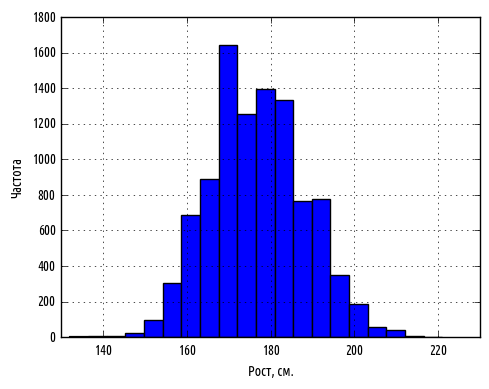

In [214]:
def ex_3_2():
    '''Визуализаия разброса значений 
       роста спортсменов на гистограмме'''
    df = load_data()
    df['Рост, см'].hist(bins=20)
    plt.xlabel('Рост, см.')
    plt.ylabel('Частота')
    #saveplot('ex_3_2.png')  
    plt.show() 
    
ex_3_2()

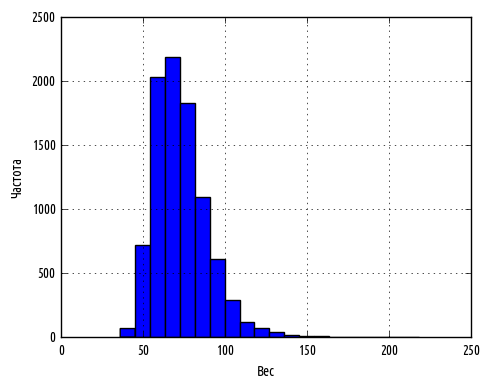

In [215]:
def ex_3_3():
    '''Визуализаия разброса значений веса спортсменов'''
    df = load_data()
    df['Вес'].hist(bins=20)
    plt.xlabel('Вес')
    plt.ylabel('Частота')
    #saveplot('ex_3_3.png')  
    plt.show() 
    
ex_3_3()

In [138]:
def ex_3_4():
    '''Вычисление ассиметрии веса спортсменов'''
    df = load_data()
    swimmers = df[ df['Вид спорта'] == 'Swimming']
    return swimmers['Вес'].skew()
    
ex_3_4()  

0.23441459903001483

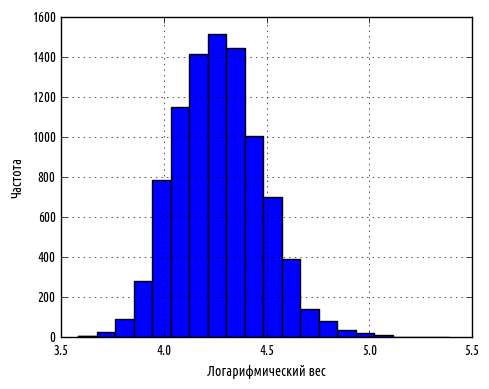

In [216]:
def ex_3_5():
    '''Визуализаия разброса значений веса спортсменов на
       полулогарифмической гистограмме с целью удаления 
       ассиметрии'''
    df = load_data()
    df['Вес'].apply(sp.log).hist(bins=20)
    plt.xlabel('Логарифмический вес')
    plt.ylabel('Частота')
    #saveplot('ex_3_5.png')  
    plt.show() 
    
ex_3_5()

### Логнормальное распределение

*Визуализация корреляции*

In [253]:
def swimmer_data():
    '''Загрузка данных роста и веса только олимпийских пловцов'''
    df = load_data()
    return df[df['Вид спорта'] == 'Swimming'].dropna()

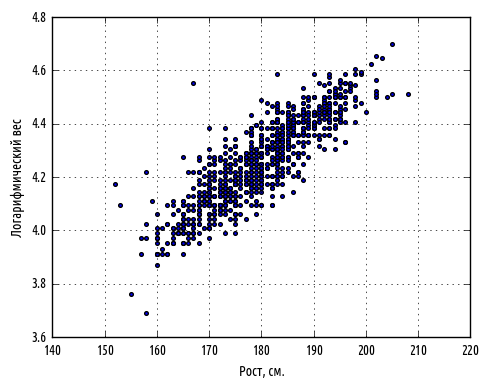

In [222]:
def ex_3_6():
    '''Визуализация корреляции между ростом и весом'''
    df = swimmer_data()
    xs = df['Рост, см']
    ys = df['Вес'].apply( sp.log )
    pd.DataFrame(sp.array([xs,ys]).T).plot.scatter(0, 1, s=7, grid=True)
    plt.xlabel('Рост, см.')
    plt.ylabel('Логарифмический вес')
    #saveplot('ex_3_6.png')  
    plt.show()
    
ex_3_6()

*Генерирование джиттера*

In [254]:
def jitter(limit):
    '''Генератор джиттера (произвольного сдвига точек данных)'''
    return lambda x: random.uniform(-limit, limit) + x

# как вариант: 
# jitter = lambda limit: lambda x: random.uniform(-limit, limit) + x
# пример вызова: jitter(0.5)(7)

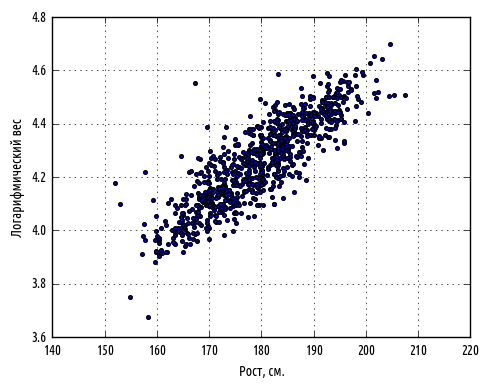

In [223]:
def ex_3_7():
    '''Визуализация корреляции между ростом и весом с джиттером'''
    df = swimmer_data()
    xs = df['Рост, см'].apply(jitter(0.5))
    ys = df['Вес'].apply(jitter(0.5)).apply(sp.log)
    pd.DataFrame(sp.array([xs,ys]).T).plot.scatter(0, 1, s=7, grid=True)
    plt.xlabel('Рост, см.')
    plt.ylabel('Логарифмический вес')
    #saveplot('ex_3_7.png')  
    plt.show()
    
ex_3_7()

### Ковариация

In [144]:
def covariance(xs, ys):
    '''Вычисление ковариации (несмещенная, т.е. n-1)'''
    dx = xs - xs.mean() 
    dy = ys - ys.mean()
    return (dx * dy).sum() / (dx.count() - 1)

In [145]:
def ex_3_custom():
    '''Вычисление ковариации 
       на примере данных роста и веса'''
    df = swimmer_data()
    return covariance(df['Рост, см'], df['Вес'].apply(sp.log))

ex_3_custom()

1.3559273321696457

In [146]:
def ex_3_pandas():
    '''Вычисление ковариации (несмещенная, т.е. n-1) в Pandas
       на примере данных роста и веса'''
    df = swimmer_data()
    return df['Рост, см'].cov(df['Вес'].apply(sp.log))

ex_3_pandas()

1.3559273321696459

### Корреляция Пирсона

In [264]:
def variance(xs):
    '''Вычисление дисперсии,
       несмещенная дисперсия при n <= 30'''
    x_hat = xs.mean()
    n = xs.count()
    n = n - 1 if n in range( 1, 30 ) else n  
    return sum((xs - x_hat) ** 2) / n

def standard_deviation(xs):
    '''Вычисление стандартного отклонения'''
    return sp.sqrt(variance(xs))

def correlation(xs, ys): 
    '''Вычисление корреляции'''
    return covariance(xs, ys) / (standard_deviation(xs) * 
                                 standard_deviation(ys))

def ex_3_8_custom():
    '''Вычисление корреляции в собственной реализации
       на примере данных роста и веса'''
    df = swimmer_data()[['Рост, см', 'Вес']]
    return correlation( df['Рост, см'], df['Вес'].apply(sp.log))

ex_3_8_custom()

0.86849354469570428

In [148]:
def ex_3_8():
    '''Вычисление корреляции средствами Pandas
       на примере данных роста и веса'''
    df = swimmer_data()
    return df['Рост, см'].corr( df['Вес'].apply(sp.log))
    
ex_3_8()

0.86748249283924894

### Проверка статистических гипотез

In [149]:
def t_statistic(xs, ys):
    '''Вычисление t-статистики
       t = corr * sqrt(df / (1 - corr**2))'''
    r = xs.corr(ys)  # как вариант, correlation(xs, ys)
    df = xs.count() - 2
    return r * sp.sqrt(df / 1 - r ** 2)

In [150]:
def ex_3_9():
    '''Выполнение двухстороннего t-теста'''
    df = swimmer_data()
    xs = df['Рост, см']
    ys = df['Вес'].apply(sp.log)
    t_value = t_statistic(xs, ys)
    df = xs.count() - 2 
    p = 2 * stats.t.sf(t_value, df)  # функция выживания (иногда лучше, чем 1-t.cdf)
    return {'t-значение':t_value, 'p-значение':p}
    
ex_3_9()

{'p-значение': 1.8980236317815443e-106, 't-значение': 25.384018200627057}

### Доверительные интервалы

In [151]:
def critical_value(confidence, ntails): # ДИ и число хвостов
    '''Расчет критического значения путем
       вычисления квантиля и получения 
       для него нормального значения'''
    lookup = 1 - ((1 - confidence) / ntails) 
    return stats.norm.ppf(lookup, 0, 1)  # mu=0, sigma=1

critical_value(0.95, 2)

1.959963984540054

In [152]:
def z_to_r(z):
    '''Преобразование z-оценки обратно в r-значение'''
    return (sp.exp(z*2) - 1) / (sp.exp(z*2) + 1)

def r_confidence_interval(crit, xs, ys):
    '''Расчет доверительного интервала для критического значения и данных'''
    r   = xs.corr(ys)
    n   = xs.count()
    zr  = 0.5 * sp.log((1 + r) / (1 - r)) 
    sez = 1 / sp.sqrt(n - 3)
    return (z_to_r(zr - (crit * sez))), (z_to_r(zr + (crit * sez)))

In [153]:
def ex_3_10():
    '''Расчет доверительного интервала 
       на примере данных роста и веса'''
    df = swimmer_data()
    X = df['Рост, см']
    y = df['Вес'].apply(sp.log)
    interval = r_confidence_interval(1.96, X, y) 
    print('ДИ (95%):', interval)
    
ex_3_10()

ДИ (95%): (0.84990885888803469, 0.8831284878884087)


### Регрессия

*Линейные уравнения*

In [154]:
'''Функция перевода из шкалы Цельсия в шкалу Фаренгейта'''
celsius_to_fahrenheit = lambda x: 32 + (x * 1.8)

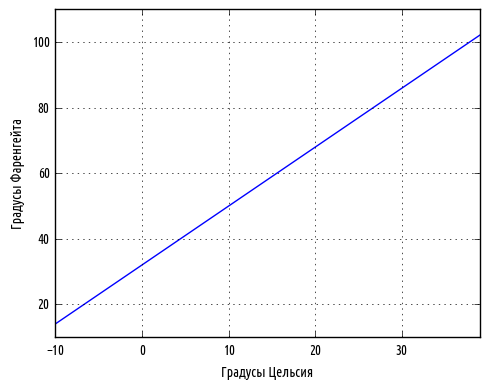

In [224]:
def ex_3_11():
    '''График линейной зависимости температурных шкал'''
    s  = pd.Series(range(-10,40))
    df = pd.DataFrame({'C':s, 'F':s.map(celsius_to_fahrenheit)})
    df.plot('C', 'F', legend=False, grid=True)
    plt.xlabel('Градусы Цельсия')
    plt.ylabel('Градусы Фаренгейта')
    #saveplot('ex_3_11.png')  
    plt.show()

ex_3_11()

### Обычный метод наименьших квадратов

*Наклон и пересечение*

In [255]:
def slope(xs, ys):
    '''Вычисление наклона линии (углового коэффициента)'''
    return xs.cov(ys) / xs.var()

def intercept(xs, ys): 
    '''Вычисление точки пересечения (с осью Y)'''
    return ys.mean() - (xs.mean() * slope(xs, ys))

In [157]:
def ex_3_12():
    '''Вычисление пересечения и наклона (углового коэффициента) 
       на примере данных роста и веса'''
    df = swimmer_data()
    X  = df['Рост, см']
    y  = df['Вес'].apply(sp.log)
    a  = intercept(X, y)
    b  = slope(X, y) 
    print('Пересечение: %f, наклон: %f' % (a,b))
    
ex_3_12()

Пересечение: 1.691033, наклон: 0.014296


*Визуализация*

In [256]:
'''Функция линии регрессии'''
regression_line = lambda a, b: lambda x: a + (b * x)  # вызовы fn(a,b)(x)

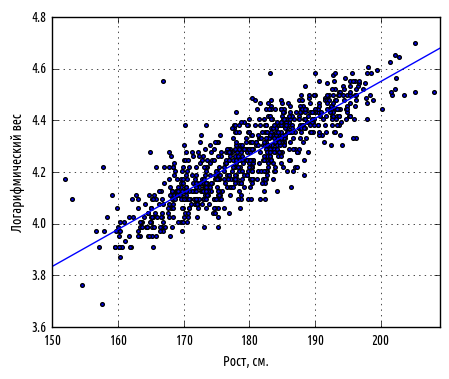

In [240]:
def ex_3_13():
    '''Визуализация линейного уравнения
       на примере данных роста и веса'''
    df = swimmer_data()
    X  = df['Рост, см'].apply( jitter(0.5) )
    y  = df['Вес'].apply(sp.log)
    a, b = intercept(X, y), slope(X, y) 
    ax = pd.DataFrame(sp.array([X, y]).T).plot.scatter(0, 1, s=7)
    s  = pd.Series(range(150,210))
    df = pd.DataFrame( {0:s, 1:s.map(regression_line(a, b))} )  
    df.plot(0, 1, legend=False, grid=True, ax=ax)
    plt.xlabel('Рост, см.')
    plt.ylabel('Логарифмический вес')
    #saveplot('ex_3_13.png')  
    plt.show()
    
ex_3_13()

In [257]:
def residuals(a, b, xs, ys):
    '''Вычисление остатков (остаточных расстояний)'''
    estimate = regression_line(a, b)         # каррирование
    return pd.Series( map(lambda x, y: y - estimate(x), xs, ys) )

constantly = lambda x: 0

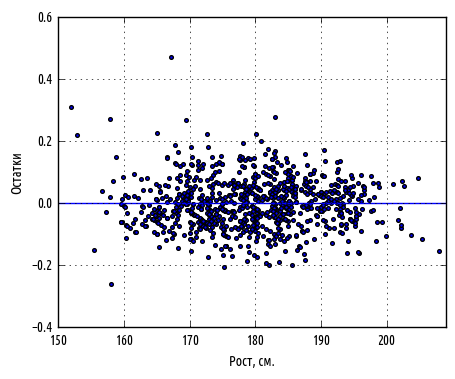

In [241]:
def ex_3_14():
    '''Построение графика остатков на примере данных роста и веса'''
    df = swimmer_data()
    X  = df['Рост, см'].apply( jitter(0.5) )
    y  = df['Вес'].apply(sp.log)
    a, b = intercept(X, y), slope(X, y) 
    y  = residuals(a, b, X, y)
    ax = pd.DataFrame(sp.array([X, y]).T).plot.scatter(0, 1, s=7)
    s  = pd.Series(range(150,210))
    df = pd.DataFrame( {0:s, 1:s.map(constantly)} )      
    df.plot(0, 1, legend=False, grid=True, ax=ax)
    plt.xlabel('Рост, см.')
    plt.ylabel('Остатки')
    #saveplot('ex_3_14.png')  
    plt.show()
    
ex_3_14()

### Качество подгонки и R-квадрат

In [258]:
def r_squared(a, b, xs, ys):
    '''Рассчитать коэффициент детерминации (R-квадрат)'''
    r_var = residuals(a, b, xs, ys).var() 
    y_var = ys.var()
    return 1 - (r_var / y_var)

In [163]:
def ex_3_15():
    '''Рассчитать коэффициент R-квадрат 
       на примере данных роста и веса'''
    df = swimmer_data()
    X  = df['Рост, см'].apply( jitter(0.5) )
    y  = df['Вес'].apply(sp.log)
    a, b = intercept(X, y), slope(X, y) 
    return r_squared(a, b, X, y)

ex_3_15()

0.75047674187068802

### Множественная линейная регрессия и матрицы

In [164]:
'''Конвертация рядов данных Series и 
   таблиц данных DataFrame библиотеки Pandas 
   в матрицы библиотеки NumPy'''
pd.Series(random.sample(range(256), k=16)).values

array([ 63, 217,   5,  96, 140, 239, 180,  99,  60, 231,  72,  44, 150,
       181,  80,  37], dtype=int64)

In [165]:
def ex_3_16():
    '''Конвертация в массив (матрицу) NumPy 
       таблицы данных роста и веса'''
    df = swimmer_data()[['Рост, см', 'Вес']]
    return df.values

ex_3_16()

array([[ 166.,   68.],
       [ 192.,   89.],
       [ 173.,   65.],
       ..., 
       [ 188.,   79.],
       [ 187.,   78.],
       [ 183.,   70.]])

In [166]:
def ex_3_17():
    '''Конвертация в массив (матрицу) NumPy 
       данных числового ряда с данными о росте'''
    return swimmer_data()['Рост, см'].head(20).values

ex_3_17()[0:10]

array([ 166.,  192.,  173.,  179.,  201.,  190.,  175.,  160.,  202.,  173.])

In [167]:
'''Добавление столбца в таблицу данных (массив)'''
df = pd.DataFrame({'x':[2, 3, 6, 7],'y':[8, 7, 4, 3]})
df['константа'] = 1
df

,x,y,константа
0,2,8,1
1,3,7,1
2,6,4,1
3,7,3,1


### Операции над матрицами в Pandas

*Конструирование*

In [168]:
df1 = pd.DataFrame([[1,0],[2,5],[3,1]])
df2 = pd.DataFrame([[4,0.5],[2,5],[0,1]])
df1

,0,1
0,1,0
1,2,5
2,3,1


In [169]:
df2

,0,1
0,4,0.5
1,2,5.0
2,0,1.0


*Сложение и скалярное произведение*

In [170]:
# Прибавление скаляра к матрице

df1 + 3

,0,1
0,4,3
1,5,8
2,6,4


In [171]:
# Сложение матриц

df1 + df2

,0,1
0,5,0.5
1,4,10.0
2,3,2.0


In [172]:
# Вычитание матриц

df1 - df2

,0,1
0,-3,-0.5
1,0,0.0
2,3,0.0


In [173]:
# Умножение матрицы на скаляр

df1 * 3

,0,1
0,3,0
1,6,15
2,9,3


In [174]:
# Матричное деление на скаляр
# эквивалентно df1.div(3, fill_value=None, axis=0, level=None)

df1 / 3

,0,1
0,0.333333,0.000000
1,0.666667,1.666667
2,1.000000,0.333333


*Матрично-векторное умножение*

In [175]:
df3 = pd.DataFrame([[1,3],[0,4],[2,1]])
vec = [1,5]
df3.dot(vec)

0    16
1    20
2     7
dtype: int64

*Матрично-матричное умножение*

In [176]:
df3 = pd.DataFrame([[1,3],[0,4],[2,1]])
df4 = pd.DataFrame([[1,0],[5,6]])     
df3.dot(df4)

,0,1
0,16,18
1,20,24
2,7,6


In [177]:
# Вариант 2

sp.matmul(df3,df4)

array([[16, 18],
       [20, 24],
       [ 7,  6]], dtype=int64)

*Транспонирование*

In [178]:
df3.T

,0,1,2
0,1,0,2
1,3,4,1


*Нейтральная (единичная) матрица*

In [179]:
pd.DataFrame(sp.identity(5))

,0,1,2,3,4
0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,1.0


*Обратная матрица*

In [180]:
# sp.random.seed([3,1415])
df5 = pd.DataFrame(sp.random.rand(3, 3), list('abc'), list('xyz'))
print(df5)
df_inv = pd.DataFrame(sp.linalg.pinv(df5.values), df5.columns, df5.index)
df_inv

          x         y         z
a  0.746842  0.949095  0.382008
b  0.194682  0.384491  0.392173
c  0.602660  0.790661  0.634435


,a,b,c
x,-2.364209,-10.726916,8.054345
y,4.033196,8.707432,-7.810945
z,-2.780548,-0.661922,3.659604


In [181]:
# проверяем
df_inv.dot(df5)

,x,y,z
x,1.000000e+00,8.881784e-16,0.0
y,-8.881784e-16,1.000000e+00,0.0
z,1.332268e-15,8.881784e-16,1.0


### Нормальное уравнение

In [259]:
# Реализация нормального уравнения

# numpy.linalg.inv(A) фактически вызывает numpy.linalg.solve(A,I), 
# где I - это нейтральная матрица, и находит решение разложением 
# LU матрицы средствами динамической библиотеки lapack
# как вариант:
# numpy.linalg.pinv - вычисляет псевдообратную матрицу (А+) по методу 
# Мура-Пенроуза с использованием сингулярного разложения (SVD)
# sp.linalg.pinv(x.values), x.columns, x.index 

def normal_equation(x, y):
    '''Реализация нормального уравнения'''
    xtx  = sp.matmul(x.T.values, x.values) 
    xtxi = sp.matmul(sp.linalg.inv(sp.matmul(xtx.T,xtx)),xtx.T)  # вычислить мультипликативную инверсию матрицы
    xty  = sp.matmul(x.T.values, y.values) 
    return sp.matmul(xtxi, xty)  

In [183]:
def ex_3_18():
    '''Решение нормального уравнения 
       на примере данных роста и веса'''
    df = swimmer_data()
    X = df[['Рост, см']] 
    X.insert(0, 'константа', 1)
    y = df['Вес'].apply( sp.log )
    return normal_equation(X, y)

ex_3_18()

array([ 1.6910337 ,  0.01429648])

*Дополнительные признаки*

In [184]:
def ex_3_19():
    '''Пример создания матрицы признаков NumPy
       на примере данных роста и возраста'''
    X = swimmer_data()[['Рост, см', 'Возраст']]
    X.insert(0, 'константа', 1)
    return X.values

ex_3_19()

array([[   1.,  166.,   23.],
       [   1.,  192.,   22.],
       [   1.,  173.,   20.],
       ..., 
       [   1.,  188.,   24.],
       [   1.,  187.,   19.],
       [   1.,  183.,   22.]])

In [185]:
def ex_3_20():
    '''Решение нормального уравнения 
       для данных роста и возраста в качестве независимых и 
       веса в качестве зависимой переменной'''
    df = swimmer_data()
    X = df[['Рост, см', 'Возраст']] 
    X.insert(0, 'константа', 1)
    y = df['Вес'].apply(sp.log)
    return normal_equation(X, y)

ex_3_20()

array([ 1.69002288,  0.01395437,  0.00279859])

### Множественный R-квадрат

In [260]:
def matrix_r_squared(coefs, x, y):
    '''Вычислить матричный R-квадрат'''
    fitted      = x.dot(coefs) 
    residuals   = y - fitted 
    difference  = y - y.mean()  
    rss         = residuals.dot(residuals)  # сумма квадратов
    ess         = difference.dot(difference)
    return 1 - (rss / ess)

In [187]:
def ex_3_21():
    '''Вычислить матричный R-квадрат 
       на данных роста и возраста в качестве независимых и 
       веса в качестве зависимой переменной'''
    df = swimmer_data()
    X = df[['Рост, см', 'Возраст']] 
    X.insert(0, 'константа', 1)
    y = df['Вес'].apply(sp.log)
    beta = normal_equation(X, y) 
    return matrix_r_squared(beta, X, y)

ex_3_21()

0.75684665474591584

### Скорректированный матричный R-квадрат

In [261]:
def matrix_adj_r_squared(coefs, x, y):
    '''Вычислить скорректированный матричный R-квадрат'''
    r_squared = matrix_r_squared(coefs, x, y) 
    n = y.shape[0]  # строки
    p = coefs.shape[0]
    dec = lambda x: x-1
    return 1 - (1 - r_squared) * (dec(n) / dec(n-p))

In [189]:
def ex_3_22():
    '''Вычислить скорректированный матричный R-квадрат 
       на данных роста и возраста в качестве независимых и 
       веса в качестве зависимой переменной'''
    df = swimmer_data()
    X = df[['Рост, см', 'Возраст']] 
    X.insert(0, 'константа', 1)
    y = df['Вес'].apply(sp.log)
    beta = normal_equation(X, y) 
    return matrix_adj_r_squared(beta, X, y)

ex_3_22()

0.75599348511344533

*Линейная модель в NumPy и SciPy*

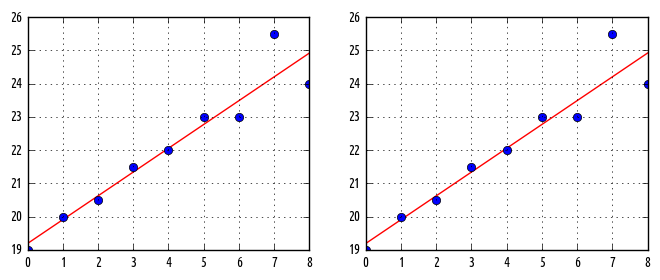

In [227]:
'''
функция numpy.linalg.pinv аппроксимирует псевдоинверсию Мура-Пенроуза 
с использованием SVD (точнее, метод dgesdd динамической библиотеки lapack), 
тогда как scipy.linalg.pinv находит решение линейной системы с точки 
зрения наименьших квадратов, чтобы аппроксимировать псевдоинверсию 
(пользуясь dgelss). Отсюда и разница и в производительности.

Производительность функции scipy.linalg.pinv2 сравнима с   
numpy.linalg.pinv, т.к. в ней используется метод SVD, вместо 
аппроксимации по методу МНК'''

def numpy_scipy():
    '''Линейная регрессия в NumPy и SciPy'''
    _, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,3))
    xi = sp.arange(0,9)
    A  = sp.array([xi, sp.ones(9)])
    y  = [19, 20, 20.5, 21.5, 22, 23, 23, 25.5, 24] # линейная последовательность

    # реализация в numpy
    (a, b) = sp.linalg.lstsq(A.T, y)[0] # получение параметров
    line = a * xi + b                   # линия регрессии 
    ax[0].plot(xi, line, 'r-', xi, y, 'o')
    ax[0].grid(True)

    # реализация в scipy
    slope, intercept, r_value, p_value, std_err = stats.linregress(xi, y)
    line = slope * xi + intercept
    #print('r-значение', r_value, 'p-значение', p_value, 'СТО', std_err)
    ax[1].plot(xi, line, 'r-', xi, y, 'o')
    ax[1].grid(True)
    plt.show()
    
numpy_scipy()

In [262]:
def linear_model(x, y):
    '''Обертка вокруг библиотечной функции 
       линейной регресси по МНК, 
       вместо собственной реализации нормального уравнения normal_equation'''
    return sp.linalg.lstsq(x,y)[0]
    #return stats.linregress(xi, y)  # наклон, пересечение, r-значение, p-значение, сош 

In [192]:
def ex_3_linear_model():
    '''Проверка функции linear_model'''
    df = swimmer_data()
    X = df[['Рост, см', 'Возраст']]
    X.insert(0, 'константа', 1.0)
    y = df['Вес'].apply(sp.log)

    beta = linear_model(X,y)
    return beta   # проверка модели sp.dot(Xi,beta_hat)

ex_3_linear_model()

array([ 1.69002404,  0.01395436,  0.00279859])

In [193]:
def f_test(fitted, x, y):
    '''F-тест коэффициентов регрессии'''
    difference = fitted - y.mean() 
    residuals  = y - fitted
    ess        = difference.dot(difference) # сумма квадратов
    rss        = residuals.dot(residuals)
    p          = x.shape[1]    # столбцы
    n          = y.shape[0]    # строки
    df1        = p - 1
    df2        = n - p
    msm        = ess / df1
    mse        = rss / df2
    f_stat     = msm / mse     # mse модели / mse остатков
    f_test     = 1-stats.f.cdf(f_stat, df1, df2) 
    return f_test

In [194]:
def ex_3_23():
    '''Проверка значимости модели на основе F-теста
       на примере данных роста, возраста и веса'''
    df = swimmer_data()
    X = df[['Рост, см', 'Возраст']]
    X.insert(0, 'константа', 1.0)
    y = df['Вес'].apply(sp.log)
    beta = linear_model(X, y)    
    fittedvalues = sp.dot(X,beta) 

    #model = sm.OLS(y, X)
    #results = model.fit()
    #print(results.summary())
    #print(1-stats.f.cdf(results.fvalue, results.df_model, results.df_resid))
    
    # проверка коэффициентов модели
    return ('F-тест', f_test(fittedvalues, X, y))

ex_3_23()

('F-тест', 1.1102230246251565e-16)

In [195]:
def ex_3_24():
    '''Проверка значимости модели на основе F-теста
       на произвольной выборке из данных роста, возраста и веса'''
    df = swimmer_data().sample(5)  # произвольная выборка
    df.index = range(len(df))      # задать новый индекс
    X = df[['Рост, см', 'Возраст']]
    X.insert(0, 'константа', 1.0)
    y = df['Вес'].apply(sp.log) 
    beta = linear_model(X, y)    
    fittedvalues = sp.dot(X,beta) 

    #model = sm.OLS(y, X)
    #results = model.fit()
    #print(results.summary())
    
    return ('F-тест', f_test(fittedvalues, X, y))

ex_3_24()

('F-тест', 0.21803901865867825)

*Категориальные и фиктивные переменные*

In [196]:
'''Перекодировать строковое в числовое представление'''
dummy_labels = lambda x: 1.0 if x == 'М' else 0.0  

In [197]:
def ex_3_25():
    '''Обработка категориальных признаков 
       (создание бинарной переменной)'''
    df = swimmer_data()
    # как вариант, получить из категориального поля несколько 
    # прямокодированных бинарных полей
    # dummies = pd.get_dummies(df['Пол'], prefix='бин_')  
    # X = df[['Рост, см', 'Возраст']].join(dummies)
    df['бин_Пол'] = df['Пол'].map(dummy_labels) 

    X = df[['Рост, см', 'Возраст', 'бин_Пол']] 
    X.insert(0, 'константа', 1)
    y = df['Вес'].apply(sp.log)  
    
    beta = linear_model(X, y) 
    return matrix_adj_r_squared(beta, X, y)

ex_3_25()

0.8082954905432822

*Относительная мощность*

In [198]:
def beta_weight(coefs, x, y):
    '''Вычисление относительного вклада каждого признака'''
    sdx = x.std()
    sdy = y.std()
    return [x / sdy * c for x,c in zip(sdx,coefs)] 

In [199]:
def ex_3_26():
    '''Относительный вклад каждого признака в предсказании веса
       на примере данных роста, возраста и пола'''
    df = swimmer_data()
    # получить единое бинарное поле
    df['бин_Пол'] = df['Пол'].map(dummy_labels) 
    X = df[['Рост, см', 'Возраст', 'бин_Пол']] 
    X.insert(0, 'константа', 1)
    y = df['Вес'].apply(sp.log) 
    beta = linear_model(X, y) 
    res = beta_weight(beta, X, y)
    #result = sm.OLS(y, X).fit()
    #print(result.summary())    
    return res

ex_3_26()

[0.0, 0.65014691350333609, 0.058429981575126667, 0.30387262631851564]

### Коллинеарность

In [200]:
'''Служебная функция приведения строкового 
   представления даты к типу DateTime и извлечение года'''
str_to_year = lambda x: pd.to_datetime(x).year

In [201]:
def ex_3_27():
    '''Относительный вклад признаков в предсказании веса
       с участием признака с датой (год)'''
    df = swimmer_data()
    df['бин_Пол'] = df['Пол'].map(dummy_labels) 
    df['Год рождения'] = df['Дата рождения'].map(str_to_year)
    X = df[['Рост, см', 'Возраст', 'бин_Пол', 'Год рождения']] 
    X.insert(0, 'константа', 1.0)
    y = df['Вес'].apply(sp.log) 
    
    beta = linear_model(X, y) 
    #result = sm.OLS(y, X).fit()
    #print(result.summary())    
    return beta_weight(beta, X, y)

ex_3_27()  

[-0.0,
 0.65007047519616024,
 0.095802827234225535,
 0.30414311150299445,
 0.03769748899241715]

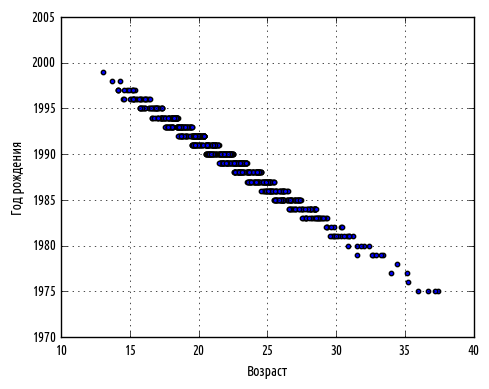

In [229]:
def ex_3_28():
    '''График коллинеарности возраста спортсменов и даты их рождения'''
    df = swimmer_data()
    df['Год рождения'] = df['Дата рождения'].map(str_to_year)
    xs = df['Возраст'].apply(jitter(0.5))
    ys = df['Год рождения']
    pd.DataFrame(sp.array([xs,ys]).T).plot.scatter(0, 1, s=10, grid=True)
    plt.xlabel('Возраст')
    plt.ylabel('Год рождения')
    #saveplot('ex_3_28.png')
    plt.show()
    
ex_3_28()

### Предсказание

In [203]:
def predict(coefs, x): 
    '''функция предсказания'''
    return sp.matmul(coefs, x.values) 

In [204]:
def ex_3_29():
    '''Вычисление ожидаемого веса спортсмена'''
    df = swimmer_data()
    df['бин_Пол'] = df['Пол'].map(dummy_labels) 
    df['Год рождения'] = df['Дата рождения'].map(str_to_year)
    X = df[['Рост, см', 'бин_Пол', 'Год рождения']] 
    X.insert(0, 'константа', 1.0)
    y = df['Вес'].apply(sp.log) 
    beta = linear_model(X, y)
    xspitz = pd.Series([1.0, 183, 1, 1950]) # параметры Марка Шпитца
    return sp.exp( predict(beta, xspitz) )  

ex_3_29()   

84.20713139038179

*Доверительный интервал предсказания*

In [243]:
def prediction_interval(x, y, xp):
    '''Вычисление предсказательного интервала'''
    xtx    = sp.matmul(x.T, x)
    xtxi   = sp.linalg.inv(xtx)  
    xty    = sp.matmul(x.T, y) 
    coefs  = linear_model(x, y) 
    fitted = sp.matmul(x, coefs)
    resid  = y - fitted
    rss    = resid.dot(resid)  
    n      = y.shape[0]  # строки
    p      = x.shape[1]  # столбцы
    dfe    = n - p 
    mse    = rss / dfe
    se_y   = sp.matmul(sp.matmul(xp.T, xtxi), xp)
    t_stat = sp.sqrt(mse * (1 + se_y))         # t-статистика
    intl   = stats.t.ppf(0.975, dfe) * t_stat   
    yp     = sp.matmul(coefs.T, xp)
    return sp.array([yp - intl, yp + intl])

In [206]:
def ex_3_30():
    '''Предсказательный интервал 
       применительно к данным о Марке Шпитце'''
    df = swimmer_data()
    df['бин_Пол'] = df['Пол'].map(dummy_labels) 
    df['Год рождения'] = df['Дата рождения'].map(str_to_year)
    X = df[['Рост, см', 'бин_Пол', 'Год рождения']] 
    X.insert(0, 'константа', 1.0)
    y = df['Вес'].apply(sp.log) 
    xspitz = pd.Series([1.0, 183, 1, 1950])  # данные М.Шпитца
    return sp.exp( prediction_interval(X, y, xspitz) )

ex_3_30()  

array([ 72.74964444,  97.46908087])

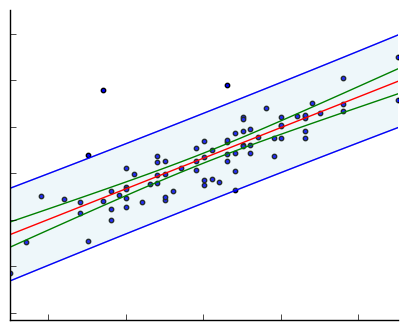

In [263]:
def ex_3_CIPI():
    '''Сравнение доверительного и предсказательного интервалов
       относительно значений независимой переменной 
       в заданном диапазоне'''
    df = swimmer_data()[['Рост, см', 'Вес']].sample(80) 
    X  = df[['Рост, см']].apply(jitter(0.5))
    X.insert(0, 'константа', 1.0)
    y  = df['Вес'].apply(jitter(0.5)).apply(sp.log) 

    # вывести точки данных
    ax = pd.DataFrame(sp.array([X['Рост, см'],y]).T).plot.scatter(0, 1, s=10, grid=True)  

    # линия регрессии
    a  = intercept(X['Рост, см'], y)
    b  = slope(X['Рост, см'], y) 
    s  = pd.Series(range(150 ,210))
    df = pd.DataFrame( {0:s, 1:s.map(regression_line(a, b))} )  
    ax = df.plot(0, 1, color='r', legend=False, ax=ax)

    # предсказательный интервал (нижняя и верхняя границы)
    bound = lambda i: lambda x: prediction_interval(X, y, pd.Series([1.0, x]))[i]
    defbound = lambda b: pd.DataFrame( {0:s, 1:s.map(bound(b))} )
    lo, hi = defbound(0), defbound(1)
    ax = lo.plot(0, 1, color='b', legend=False, ax=ax)
    ax = hi.plot(0, 1, color='b', legend=False, ax=ax)
    ax.fill_between(lo[0], lo[1], hi[1], alpha=0.2, facecolor='lightblue', interpolate=True) 
    
    # доверительный интервал
    n      = X.shape[0]
    alpha  = 0.05
    fit    = lambda xx: a + b*xx  
    dfr    = n-2
    tval   = stats.t.isf(alpha/2., dfr) # соответствующее t-значение
    se_fit = lambda x: sp.sqrt(sp.sum((y - fit(x))**2)/(n-2)) * \
                       sp.sqrt(1./n + (x-sp.mean(x))**2/(sp.sum(x**2) - sp.sum(x)**2/n))

    X = X['Рост, см'].sort_values()
    ax.plot(X, fit(X)-tval*se_fit(X), 'g')
    ax.plot(X, fit(X)+tval*se_fit(X), 'g')
    
    # настройка графика 
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlim(min(X), max(X))
    ax.set_ylim(min(y)-0.2, max(y)+0.2)
    ax.tick_params(labelbottom='off')
    ax.tick_params(labelleft='off')
    ax.set_xlabel('')
    ax.set_ylabel('')
    #saveplot('ex_3_CIPI.png')
    plt.show()

ex_3_CIPI()

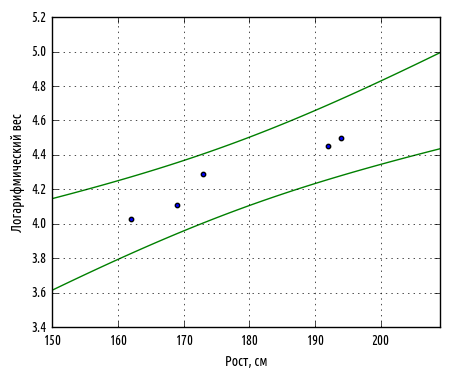

In [249]:
def ex_3_31():
    '''График изменения предсказательного интервала
       относительно значений независимой переменной 
       в заданном диапазоне '''
    df = swimmer_data().sample(5)  # произвольная выборка
    X = df[['Рост, см']]
    X.insert(0, 'константа', 1.0)
    y = df['Вес'].apply(sp.log) 

    bound = lambda i: lambda x: prediction_interval(X, y, pd.Series([1.0, x]))[i]
    s = pd.Series(range(150 ,210))
    defbound = lambda b: pd.DataFrame( {0:s, 1:s.map(bound(b))} )

    df = pd.DataFrame(sp.array([X['Рост, см'],y]).T)
    ax = df.plot.scatter(0, 1, s=10, grid=True)  
    ax = defbound(0).plot(0, 1, legend=False, color='g', ax=ax)
    defbound(1).plot(0, 1, legend=False, grid=True, color='g', ax=ax)
    
    plt.xlabel('Рост, см')
    plt.ylabel('Логарифмический вес')
    #saveplot('ex_3_31.png')
    plt.show()

ex_3_31()

*Окончательная модель*

In [250]:
def ex_3_32():
    '''Окончательная модель для предсказания 
       соревновательного веса'''
    df = swimmer_data()
    df['бин_Пол'] = df['Пол'].map(dummy_labels) 
    X = df[['Рост, см', 'бин_Пол', 'Возраст']] 
    X.insert(0, 'константа', 1.0)
    y = df['Вес'].apply(sp.log) 

    beta = linear_model(X, y)
    # предсказать вес для М.Шпитца
    xspitz = pd.Series([1.0, 185, 1, 22]) 
    return sp.exp( predict(beta, xspitz) )

ex_3_32()   

78.468827726302962

<a href="#home"><i class="fa fa-home fa-fw"></i></a><br><br>